In [1]:
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models

In [2]:
import scipy.io as sio

data = sio.loadmat('PaviaU.mat')
label = sio.loadmat('PaviaU_gt.mat')
print("文件中的字段名:", data.keys())  # 输出类似：dict_keys(['__header__', '__version__', '__globals__', 'data', 'gt'])
print("文件中的字段名:", label.keys())  # 输出类似：dict_keys(['__header__', '__version__', '__globals__', 'data', 'gt'])

文件中的字段名: dict_keys(['__header__', '__version__', '__globals__', 'paviaU'])
文件中的字段名: dict_keys(['__header__', '__version__', '__globals__', 'paviaU_gt'])


In [3]:
def load_PaviaU(data_path='PaviaU.mat', label_path='PaviaU_gt.mat'):
    """
    加载Indian Pines数据集
    :param data_path: 高光谱数据文件路径（.mat）
    :param label_path: 标签数据文件路径（.mat）
    :return: X_train, X_test, y_train, y_test, original_shape
    """
    # --- 1. 加载数据 ---
    data = sio.loadmat(data_path)
    labels = sio.loadmat(label_path)
    
    # 提取数据字段（注意不同数据集可能使用不同字段名，需根据实际文件调整）
    # Indian Pines常用字段名：'indian_pines' (145x145x200) 或 'data'
    # 标签字段名：'indian_pines_gt' (145x145) 或 'gt'
    hsi = data['paviaU'].astype(np.float32)  # 若字段名不同，需修改此处
    gt = labels['paviaU_gt'].astype(np.int32)  # 若字段名不同，需修改此处
    
    # --- 2. 展平数据并过滤未标记像素 ---
    height, width, bands = hsi.shape
    hsi_flat = hsi.reshape(-1, bands)  # 形状: (145*145, 200) = (21025, 200)
    gt_flat = gt.flatten()             # 形状: (21025,)
    
    # 过滤未标记像素（假设标签0为未标记）
    mask = gt_flat != 0
    X = hsi_flat[mask]                # 形状: (N_valid, 200)
    y = gt_flat[mask] - 1             # 转换为0-based标签
    
    
    return X, y, hsi.shape,mask
# 加载数据并获取关键变量
X,  y, original_shape, mask = load_PaviaU()
height, width, bands = original_shape
print("有效像素数量:", mask.sum())  # 应与y的长度一致

有效像素数量: 42776


In [4]:
# --- 2. 动态F-范数降维 ---
# 计算每个波段的F-范数并保留前142个
hsi = sio.loadmat('PaviaU.mat')['paviaU'].astype(np.float32)
f_norms = np.sum(hsi**2, axis=(0, 1))
sorted_f_norms = np.sort(f_norms)[::-1]
threshold = sorted_f_norms[89]
data_reduced_f = hsi[:, :, f_norms >= threshold]
num_bands = data_reduced_f.shape[2]
print("F-范数降维后形状:", data_reduced_f.shape)

F-范数降维后形状: (610, 340, 90)


In [5]:
# --- 3. PCA降维 ---
pca = PCA(n_components=6)
data_flat_pca = data_reduced_f.reshape(-1, num_bands)
data_pca = pca.fit_transform(data_flat_pca).reshape(*original_shape[:2], 6)
print("PCA降维后形状:", data_pca.shape)  # 应为 (145, 145, 6)

PCA降维后形状: (610, 340, 6)


In [6]:
# --- 4. 提取空间特征（仅限有效像素）---
valid_indices = np.where(mask.reshape(original_shape[0], original_shape[1]))

def extract_spatial_features(data_pca, valid_indices, window_size=3):
    pad = window_size // 2
    padded = np.pad(data_pca, [(pad, pad), (pad, pad), (0,0)], mode='reflect')
    features = []
    for i, j in zip(*valid_indices):  # 仅处理有效像素
        patch = padded[i:i+window_size, j:j+window_size, :]
        features.append(patch.flatten())
    return np.array(features)

spatial_features = extract_spatial_features(data_pca, valid_indices)
print("空间特征形状:", spatial_features.shape)  # (N_valid, 54)

空间特征形状: (42776, 54)


In [7]:
# --- 5. 合并光谱和空间特征 ---
spectral_features = data_reduced_f.reshape(-1, num_bands)[mask]
combined = np.concatenate([spectral_features, spatial_features], axis=1)
print("合并后特征形状:", combined.shape)  # 应为 (N_valid, 196)
print("标签形状:", y.shape)          # 应为 (N_valid,)

合并后特征形状: (42776, 144)
标签形状: (42776,)


In [8]:
# --- 6. 数据集分割 ---
X_train, X_test, y_train, y_test = train_test_split(
    combined, y, test_size=0.2, stratify=y
)

In [9]:
# --- 8. 数据标准化 ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).reshape(-1, 12, 12, 1)
X_test_scaled = scaler.transform(X_test).reshape(-1, 12, 12, 1)
print(X_train_scaled.shape)  
print(y_train.shape) 

(34220, 12, 12, 1)
(34220,)


In [12]:
# --- 9. 构建CNN模型 ---
fmodel = models.Sequential([
    layers.Flatten(input_shape=(12,12,1)),
    layers.Dense(25, activation='sigmoid'),
    layers.Dense(9, activation='softmax')
])
fmodel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 144)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         3,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │           234 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,859 (15.07 KB)

 Trainable params: 3,859 (15.07 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
import pandas as pd
import os
from datetime import datetime

class TrainingLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_dir="training_logs"):
        super().__init__()
        self.log_dir = log_dir
        self.log_data = []
        
        # 创建日志目录（处理Anaconda环境权限问题）
        os.makedirs(self.log_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        """每个epoch结束时记录指标"""
        logs = logs or {}
        self.log_data.append({
            "Epoch": epoch + 1,
            "Train Loss": logs.get("loss"),
            "Train Acc": logs.get("accuracy"),
            "Val Loss": logs.get("val_loss"),
            "Val Acc": logs.get("val_accuracy")
        })

    def on_train_end(self, logs=None):
        """训练结束时保存到Excel"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = os.path.join(self.log_dir, f"training_log7_{timestamp}.xlsx")
        
        try:
            df = pd.DataFrame(self.log_data)
            # 设置显示精度
            df = df.round({
                "Train Loss": 4,
                "Train Acc": 4,
                "Val Loss": 4,
                "Val Acc": 4
            })
            
            df.to_excel(filename, index=False, engine="openpyxl")
            print(f"日志已保存至：{os.path.abspath(filename)}")
        except Exception as e:
            print(f"保存失败：{str(e)}")

# 示例用法
if __name__ == "__main__":
    # 配置参数
    LOG_PATH = "D:/ML_Logs"  # Windows示例路径（建议使用绝对路径）
    
fmodel.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1.0),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# --- 10. 训练和评估 ---
FNN_history = fmodel.fit(X_train_scaled, y_train, epochs=30, 
                    validation_data=(X_test_scaled, y_test),batch_size=32,callbacks=[TrainingLogger(LOG_PATH)])
test_loss, test_acc = fmodel.evaluate(X_test_scaled, y_test)

Epoch 1/30
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8304 - loss: 0.4768 - val_accuracy: 0.8560 - val_loss: 0.3640
Epoch 2/30
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9292 - loss: 0.1990 - val_accuracy: 0.9350 - val_loss: 0.1858
Epoch 3/30
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9447 - loss: 0.1546 - val_accuracy: 0.9461 - val_loss: 0.1518
Epoch 4/30
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9548 - loss: 0.1277 - val_accuracy: 0.8961 - val_loss: 0.2515
Epoch 5/30
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9573 - loss: 0.1193 - val_accuracy: 0.9579 - val_loss: 0.1287
Epoch 6/30
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9617 - loss: 0.1069 - val_accuracy: 0.9626 - val_loss: 0.1067
Epoch 7/30
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9623 - loss: 0.1035 - val_accuracy: 0.9619 - val_loss: 0.1060
Epoch 8/30
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9662 - loss: 0.0947 - 

In [14]:
# --- 9. 构建CNN模型 ---
cnnmodel = models.Sequential([
    layers.Conv2D(16, (3,3), activation='sigmoid', input_shape=(12,12,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (2,2), activation='sigmoid'),
    #layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(25, activation='sigmoid'),
    layers.Dense(9, activation='softmax')
])
cnnmodel.summary()

C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 10, 10, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 4, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │        12,825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │           234 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,299 (59.76 KB)

 Trainable params: 15,299 (59.76 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
import pandas as pd
import os
from datetime import datetime

class TrainingLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_dir="training_logs"):
        super().__init__()
        self.log_dir = log_dir
        self.log_data = []
        
        # 创建日志目录（处理Anaconda环境权限问题）
        os.makedirs(self.log_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        """每个epoch结束时记录指标"""
        logs = logs or {}
        self.log_data.append({
            "Epoch": epoch + 1,
            "Train Loss": logs.get("loss"),
            "Train Acc": logs.get("accuracy"),
            "Val Loss": logs.get("val_loss"),
            "Val Acc": logs.get("val_accuracy")
        })

    def on_train_end(self, logs=None):
        """训练结束时保存到Excel"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = os.path.join(self.log_dir, f"training_log8_{timestamp}.xlsx")
        
        try:
            df = pd.DataFrame(self.log_data)
            # 设置显示精度
            df = df.round({
                "Train Loss": 4,
                "Train Acc": 4,
                "Val Loss": 4,
                "Val Acc": 4
            })
            
            df.to_excel(filename, index=False, engine="openpyxl")
            print(f"日志已保存至：{os.path.abspath(filename)}")
        except Exception as e:
            print(f"保存失败：{str(e)}")

# 示例用法
if __name__ == "__main__":
    # 配置参数
    LOG_PATH = "D:/ML_Logs"  # Windows示例路径（建议使用绝对路径）
    
cnnmodel.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1.0),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# --- 10. 训练和评估 ---
CNN_history = cnnmodel.fit(X_train_scaled, y_train, epochs=30, 
                    validation_data=(X_test_scaled, y_test),batch_size=32,callbacks=[TrainingLogger(LOG_PATH)])
test_loss, test_acc = fmodel.evaluate(X_test_scaled, y_test)

Epoch 1/30
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6307 - loss: 1.0780 - val_accuracy: 0.7741 - val_loss: 0.5927
Epoch 2/30
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8760 - loss: 0.3316 - val_accuracy: 0.9109 - val_loss: 0.2403
Epoch 3/30
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9141 - loss: 0.2275 - val_accuracy: 0.8090 - val_loss: 0.4658
Epoch 4/30
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9282 - loss: 0.1900 - val_accuracy: 0.9305 - val_loss: 0.1804
Epoch 5/30
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9394 - loss: 0.1646 - val_accuracy: 0.9317 - val_loss: 0.1842
Epoch 6/30
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9467 - loss: 0.1414 - val_accuracy: 0.9540 - val_loss: 0.1195
Epoch 7/30
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9505 - loss: 0.1280 - val_accuracy: 0.9307 - val_loss: 0.1882
Epoch 8/30
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9569 - loss: 0.1147 - 

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Lambda
from tensorflow.keras.models import Model
import pennylane as qml
from pennylane.qnn import KerasLayer
import sympy
import collections
# 定义量子电路
n_qubits = 5
dev = qml.device("default.qubit", wires=n_qubits)
# 定义量子电路（确保输出为float32）
@qml.qnode(dev, interface="tf")  # 确保使用 TensorFlow 接口
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]  # 正确返回期望值

n_layers = 3
weight_shapes = {"weights": (n_layers, n_qubits)}

# 创建自定义分割层
def split_layer(x):
    return tf.split(x, 5, axis=1)

# 创建TensorFlow模型
def create_model(input_shape=(12, 12, 1)):
    input_layer = Input(shape=input_shape)
    
    # 卷积部分
    x = Conv2D(16, kernel_size=3, activation='sigmoid', padding='valid')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, kernel_size=2, activation='sigmoid', padding='valid')(x)

    # 展平并连接全连接层
    x = Flatten()(x)
    #x = Dense(120, activation='sigmoid')(x)
    x = Dense(25, activation='sigmoid')(x)
    
    # 使用Lambda层进行张量分割
    splits = Lambda(split_layer)(x)  # 关键修改
    
    # 创建 KerasLayer 并指定 dtype
    qlayers = [
        KerasLayer(qnode, weight_shapes, output_dim=n_qubits, dtype=tf.float32)
        for _ in range(5)
    ]

    
    # 在模型中将量子层输出转换为实数（冗余保险）
    q_outputs = [qlayers[i](splits[i]) for i in range(5)]
    q_outputs = [Lambda(lambda x: tf.math.real(x))(out) for out in q_outputs]
    concat = Concatenate()(q_outputs)
    output = Dense(9)(concat)
    
    return Model(inputs=input_layer, outputs=output)

# 创建并验证模型
qcnn_model = create_model()
qcnn_model.summary()

C:\Users\Administrator\anaconda3\Lib\site-packages\pennylane\qnn\keras.py:317: PennyLaneDeprecationWarning: The 'KerasLayer' class is deprecated and will be removed in v0.42. 
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 12, 12, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 10, 10,    │        160 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 5, 5, 16)  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 4, 32)  │      2,080 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 512)       │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 25)        │     12,825 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ [(None, 5),       │          0 │ dense_6[0][0]     │
│                     │ (None, 5), (None, │            │                   │
│                     │ 5), (None, 5),    │            │                   │
│                     │ (None, 5)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_layer         │ (None, 5)         │         15 │ lambda[0][0]      │
│ (KerasLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_layer_1       │ (None, 5)         │         15 │ lambda[0][1]      │
│ (KerasLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_layer_2       │ (None, 5)         │         15 │ lambda[0][2]      │
│ (KerasLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_layer_3       │ (None, 5)         │         15 │ lambda[0][3]      │
│ (KerasLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_layer_4       │ (None, 5)         │         15 │ lambda[0][4]      │
│ (KerasLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 5)         │          0 │ keras_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 5)         │          0 │ keras_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 5)         │          0 │ keras_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 5)         │          0 │ keras_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 5)         │          0 │ keras_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 25)        │          0 │ lambda_1[0][0],   │
│ (Concatenate)       │                   │            │ lambda_2[0][0],   │
│                     │                   │            │ lambda_3[0][0],   │
│                     │                   │            │ lambda_4[0][0], 

 Total params: 15,374 (60.05 KB)

 Trainable params: 15,374 (60.05 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
import pandas as pd
import os
from datetime import datetime

class TrainingLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_dir="training_logs"):
        super().__init__()
        self.log_dir = log_dir
        self.log_data = []
        
        # 创建日志目录（处理Anaconda环境权限问题）
        os.makedirs(self.log_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        """每个epoch结束时记录指标"""
        logs = logs or {}
        self.log_data.append({
            "Epoch": epoch + 1,
            "Train Loss": logs.get("loss"),
            "Train Acc": logs.get("accuracy"),
            "Val Loss": logs.get("val_loss"),
            "Val Acc": logs.get("val_accuracy")
        })

    def on_train_end(self, logs=None):
        """训练结束时保存到Excel"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = os.path.join(self.log_dir, f"training_log9_{timestamp}.xlsx")
        
        try:
            df = pd.DataFrame(self.log_data)
            # 设置显示精度
            df = df.round({
                "Train Loss": 4,
                "Train Acc": 4,
                "Val Loss": 4,
                "Val Acc": 4
            })
            
            df.to_excel(filename, index=False, engine="openpyxl")
            print(f"日志已保存至：{os.path.abspath(filename)}")
        except Exception as e:
            print(f"保存失败：{str(e)}")

# 示例用法
if __name__ == "__main__":
    # 配置参数
    LOG_PATH = "D:/ML_Logs"  # Windows示例路径（建议使用绝对路径）

# 配置模型优化
qcnn_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1.0),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
# 执行训练
history = qcnn_model.fit(
    X_train_scaled, 
    y_train, 
    epochs=30,
    validation_data=(X_test_scaled, y_test),
    callbacks=[TrainingLogger(LOG_PATH)]
    )
# 评估最终性能
test_loss, test_acc = qcnn_model.evaluate(X_test_scaled, y_test)

Epoch 1/30
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - accuracy: 0.5404 - loss: 1.3729 - val_accuracy: 0.8683 - val_loss: 0.3736
Epoch 2/30
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8507 - loss: 0.3974 - val_accuracy: 0.9057 - val_loss: 0.2702
Epoch 3/30
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8907 - loss: 0.2963 - val_accuracy: 0.9049 - val_loss: 0.2655
Epoch 4/30
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9115 - loss: 0.2417 - val_accuracy: 0.8655 - val_loss: 0.4228
Epoch 5/30
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9194 - loss: 0.2180 - val_accuracy: 0.8410 - val_loss: 0.3884
Epoch 6/30
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9306 - loss: 0.1870 - val_accuracy: 0.9239 - val_loss: 0.1995
Epoch 7/30
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9375 - loss: 0.1696 - val_accuracy: 0.9440 - val_loss: 0.1665
Epoch 8/30
1070/1070 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9440 -

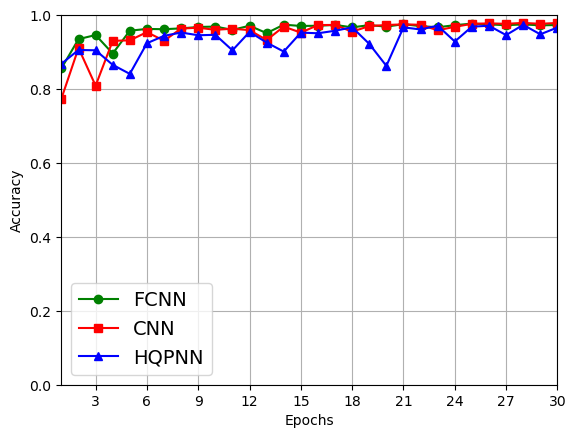

In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt
def plot_acc_curves(fc_acc, cnn_acc, qcnn_acc):
    fig = plt.figure()
    plt.plot(np.arange(len(fc_acc)) + 1, fc_acc, "go-", label="FCNN")
    plt.plot(np.arange(len(cnn_acc)) + 1, cnn_acc, "rs-", label="CNN")
    plt.plot(np.arange(len(qcnn_acc)) + 1, qcnn_acc, "b^-", label="HQPNN")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.grid()
    plt.axis([1, 30, 0, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    fig.savefig('accuracy.png', dpi=300)
    
def plot_acc_curves_small(fc_acc, cnn_acc, qcnn_acc):
    fig = plt.figure()
    plt.plot(np.arange(len(fc_acc))[::2] + 1, fc_acc[::2], "go-", label="FCNN")
    plt.plot(np.arange(len(cnn_acc))[::2] + 1, cnn_acc[::2], "rs-", label="CNN")
    plt.plot(np.arange(len(qcnn_acc))[::2] + 1, qcnn_acc[::2], "b^-", label="HQPNN")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.grid()
    plt.axis([1, 30, 0, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    fig.savefig('accuracy_small.png', dpi=300)
plot_acc_curves(FNN_history.history['val_accuracy'], CNN_history.history['val_accuracy'], history.history['val_accuracy'])

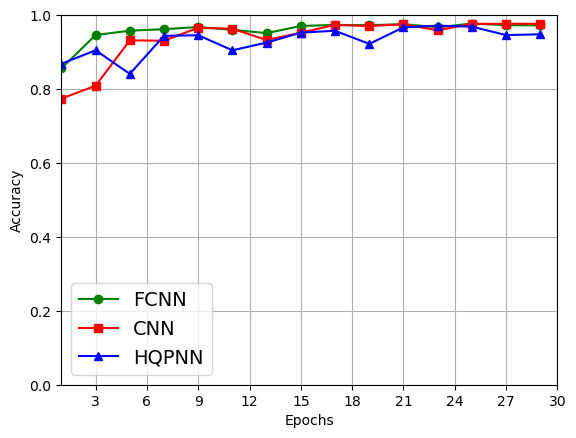

In [19]:
plot_acc_curves_small(FNN_history.history['val_accuracy'], CNN_history.history['val_accuracy'], history.history['val_accuracy'])

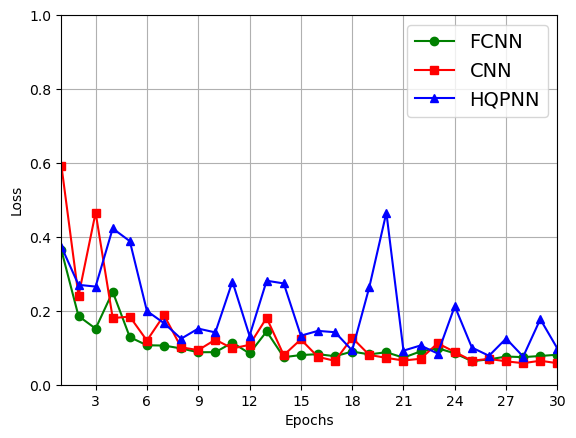

In [20]:
def plot_loss_curves(fc_loss, cnn_loss, qcnn_loss):
    fig = plt.figure()
    plt.plot(np.arange(len(fc_loss)) + 1, fc_loss, "go-", label="FCNN")
    plt.plot(np.arange(len(cnn_loss)) + 1, cnn_loss, "rs-", label="CNN")
    plt.plot(np.arange(len(qcnn_loss)) + 1, qcnn_loss, "b^-", label="HQPNN")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.grid()
    plt.axis([1, 30, 0, 1])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
plot_loss_curves(FNN_history.history['val_loss'], CNN_history.history['val_loss'], history.history['val_loss'])